<h1> Thursday Harbor: SciPy Tutorial </h1>

In [1]:
# import statements
import scipy
import scipy.signal as signal
import scipy.ndimage as ndi
import scipy.stats as stats
import scipy.optimize as optimize

from PIL import Image

In [2]:
# import statements
import numpy as np
import pandas as pd
import h5py
import skimage.feature

In [3]:
import matplotlib.pyplot as plt
%pylab inline 
pylab.rcParams['figure.figsize'] = (9, 6)

Populating the interactive namespace from numpy and matplotlib


In [31]:
import os
for f in ['MAX_ZSeries-ch1.tif', 'MAX_ZSeries-ch2.tif', 
          'power_calibrations.csv', 'sweeps.h5', 'BOb.png']:
    if not os.path.isfile(f):
        print 'please download %s' %(f)

<h2> Outline </h2>

1. Curve fitting and optimization using scipy.optimize
2. Some basic statistics using scipy.stats
3. How to load, read, and adjust an image using scipy.ndimage
4. 1D and 2D (image) filtering and signal processing using scipy.signal and scipy.ndimage

Note that during all of these modules, there will be examples of various ways to load/save and visualize data

<h2> Curve Fitting & Optimization </h2>

Many of functions we are interested in are nonlinear. A nonlinear least squares fit is an iterative process to minimize the error function (residuals) of the fit to the data provided. This is why a nonlinear least squares fit, unlike a regression, needs an initial guess for the parameters to be optimized. 

Let's start with a simple curve: we will attemt to find an analytic equation for the conversion of a laser output voltage to a mW/area power value by fitting a sigmoid to measured data. The data are saved as columns in a .csv file. The Pandas library allows us to quickly load this data and retain its tabular format. 

In [5]:
#load up the data file here
power_calib_file = 'power_calibrations.csv'
power_df = pd.read_csv(power_calib_file)
power_df.head()

,PockelVoltage,Pockel,FidelityPower,BeamDiamter(um),FidelityPowerPerArea
0,0.000000,0,0.0,1.2932,0.000000
1,0.018939,1,0.1,1.2932,0.076173
2,0.037879,2,0.1,1.2932,0.076173
3,0.056818,3,0.2,1.2932,0.152345
4,0.075758,4,0.4,1.2932,0.304691


The Pandas library also contains some "smart" (and quick) plotting functions, where we can tell the plot function which column of the dataframe we want on each axis. 

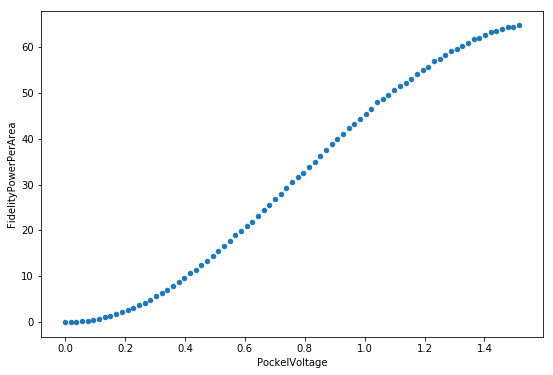

In [6]:
power_df.plot(x='PockelVoltage', y='FidelityPowerPerArea', kind='scatter')

I've written two important functions here. `sigmoid` takes as inputs a list list of 3 parameters, and either a numpy array (or scalar) of input data. It returns a numpy array (or scalar) of "output" sigmoidal data that depends on the values of the four parameters. `diff_fxn` defines the error function to be minized by SciPy's least squares functions. It is simply the difference (residuals) of the measured data and sigmoidal function. Note that we can pass the `sigmoid` function into `diff_fxn` as a parameter. This would be useful if we wanted to write several functions describing different fits, and test how well they described our data with a single error function. 

In [7]:
# params is a numpy array with 4 values; each value represents a constant used to determine the sigmoid
# x is the input array

def sigmoid(params, x):
    fx = params[0] / (np.exp(-params[1]*(x-params[2])) + 1) + params[3]
    return fx

def diff_fxn(params, fxn, x, data):
    return data - fxn(params, x)


p0 = np.array([10, -10, 1, 20]) # initial guess
voltage_input = power_df.PockelVoltage.values # input to the fitting function
measured_power = power_df.FidelityPowerPerArea.values # real data used to find fit

fit = optimize.least_squares(diff_fxn, p0, args = (sigmoid, voltage_input, measured_power))
# fit is a tuple: the first argument are the parameters found from the least squares optimization

print fit.x

[-77.43681752  -3.38188478   0.79205091  71.12823275]


SciPy's `optimize.least_squares` function takes two required inputs -- the error function and the initial parameters -- as well as any additional arguments that need to be passed into the error function (in our case, the fit function `sigmoid`, the input data (voltage_input) and the measured data (measured_power). 

The fit parameters tell us our analytic equation should take the following form:

$$
P = \frac{-77.4}{1 + {e}^{3.38*(V - 0.79)}} + 71.1
$$

Let's qualitatively see how good the parameter estimation is by passing the fit parameters into the sigmoid function and plotting it on the same axis as our measured results. 

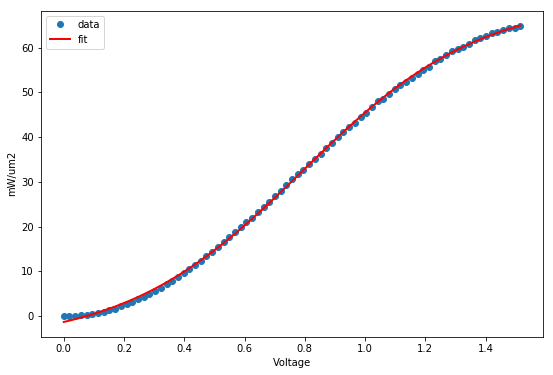

In [8]:
sigmoid_fit = sigmoid(fit.x, voltage_input)

fig = plt.figure()
ax = fig.add_subplot(111)
data = ax.plot(voltage_input, measured_power, 'o')
fit_data = ax.plot(voltage_input, sigmoid_fit, color='r', linewidth=2)
plt.legend(['data', 'fit'])
ax.set_xlabel('Voltage')
ax.set_ylabel('mW/um2')

Let's write a function that will allow us to input a voltage, and get the power value in return.

In [9]:
def v_mW_conversion(fxn, fit_params, input_value):
    mW = fxn(fit_params, input_value)
    
    if mW < 0: # make up for errors on the low-end of the fit. We know powers can't be negative!
        mW = 0
        
    return mW

mW_value = v_mW_conversion(sigmoid, fit.x, 0.67)
print 'The conversion of %f V to mW/um2 is: %f' %(0.67, mW_value)

mW_value = v_mW_conversion(sigmoid, fit.x, 0.01)
print 'The conversion of %f V to mW/um2 is: %f' %(0.01, mW_value)
    
    

The conversion of 0.670000 V to mW/um2 is: 24.530628
The conversion of 0.010000 V to mW/um2 is: 0.000000


Some additional tips:

If `optimize.least_squares` is not coverging on a reasonable solution, consider adjusting your initial parameter guess. A good way to do that would be to plot several options for each parameter and qualitatively look for a reaosnable fit to your data. Pass that guess into `least_squares` and see if a minimum can be found. 

Next, `optimize.least_squares` takes some additional arguments that can give you more control over the fitting. You can set bounds to constrain the minimization region, or the minimzation method. If computation time is an issue, the Jaocbian matrix (a matrix of the partial derivatives of each component of fit) can be defined and passed into `optimize.least_squares`. 

See more here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

Additionally, `optimize.minimize` has similar functionality, with more freedom to set various bounds and methods for optimization. `optimize.curve_fit` contains a built in error function, so it is not necessary to define this, but only the fit function, when using this module.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

<h2> Image Processing </h2>

Let's start by loading in the red and green channels of a two photon image, and convincing ourselves that images are really just matrices of pixel values. 

In [10]:
im_ch1 = ndi.imread('MAX_ZSeries-ch1.tif')
im_ch2 = ndi.imread('MAX_ZSeries-ch2.tif')
print im_ch1.shape, type(im_ch1), im_ch1.max(), im_ch1.min()

(512, 512) <type 'numpy.ndarray'> 4094 168


To create a colorful RGB image, we need to merge these two channels. To do that, let's create a numpy array full of zeros that has the same width and height as our channel arrays, but a depth of 3 (R, G, B). We can assign channel 1 (red) to the first stack, and channel 2 (green) to the second. Matplotlib has built in functions for displaying grayscale and rgb images.

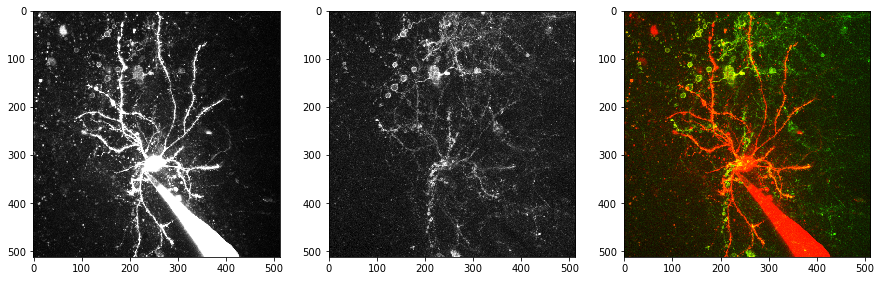

In [11]:
# How to merge color channels
rgb_im = np.zeros((im_ch1.shape[0], im_ch1.shape[1], 3), 'float32')
rgb_im[...,0] = im_ch1
rgb_im[...,1] = im_ch2

pylab.rcParams['figure.figsize'] = (15, 10) #enlarge figure size so images are easier to see

fig_image = plt.figure()
ax1 = fig_image.add_subplot(131)
ax2 = fig_image.add_subplot(132)
ax3 = fig_image.add_subplot(133)

ax1.imshow(im_ch1, cmap=plt.cm.gray)
ax2.imshow(im_ch2, cmap=plt.cm.gray)

ax3.imshow(rgb_im / rgb_im.max()) 
#For RGB images, float values must be between 0-1; so we normalize to the max


Before we can do any real analysis, we need to figure out a way to denoise our images. The methods for doing this vary widely, depending on the type of noise present in the image. One of the simplest methods we can use is to find the mean (or median) and standard deviation pixel value across the image, and convert the image to binary form. That is:

$$
pixels < mean + k*stdev = 0
$$
$$
pixels >= mean + k*stdev = 1
$$

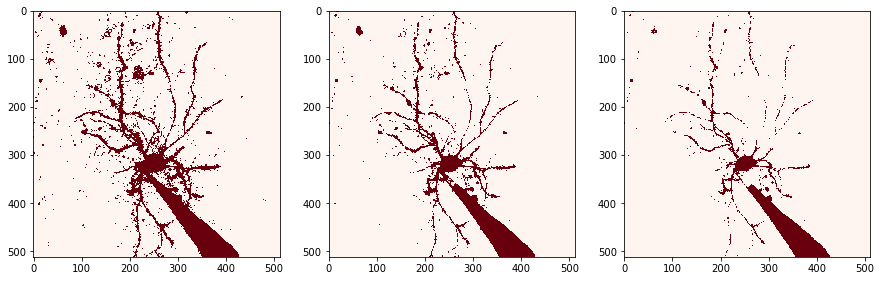

In [12]:
# Basic image thresholding to denoise
# based on mean (or median) and standard deviation: then convert to a binary image

mean_red_val = np.mean(im_ch1)
std_red_val = np.std(im_ch1)

fig_image = plt.figure()
ax1 = fig_image.add_subplot(131)
ax2 = fig_image.add_subplot(132)
ax3 = fig_image.add_subplot(133)

axis = [ax1, ax2, ax3]
thresholds = [1, 2, 3]


for ax, factor in zip(axis, thresholds):
    threshold_im = im_ch1.copy()
    
    threshold_im[im_ch1 < (mean_red_val + (factor*std_red_val))] = 0
    threshold_im[im_ch1 >= (mean_red_val + (factor*std_red_val))] = 1

    ax.imshow(threshold_im, cmap=plt.cm.Reds)



As you can probably guess, this works well for images with a faint background, where the object of interest is bright. However, it will do nothing to help bright "salt-and-pepper" noise, nor is it guaranteed to differentiate between a bright artifact and the object of interest. Additionally, the mean pixel value is dependent the size of the object of interest within the image, and it may be difficult to retain the entirety of the desired object. During the filtering section of the tutorial, we will go over a few more robust methods of filtering and object detection. 

<h2> Signal Processing </h2>

By digitally sampling a signal, we are turning a continuous signal into a discrete, finite signal, and thus introduce several limitations into how we approach extracting meaning from data. The most obvious is the sampling rate: we cannot expect to detect any periodic signal that occurs faster than half the sampling rate (Nyquist frequency) due to the potential for aliasing errors. The sampling rate thus plays a big role in the detecting frequencies in data and applying any desired filters. 

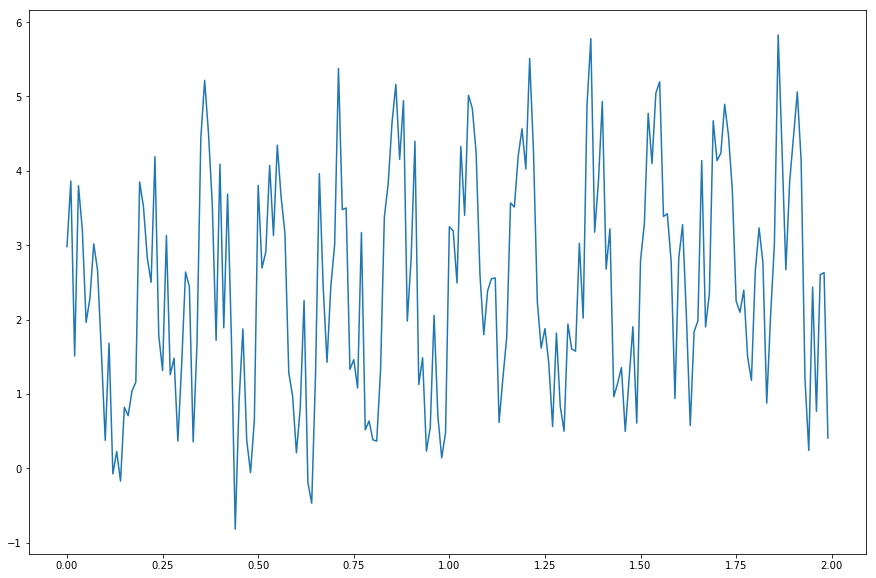

In [13]:
# make artificially noisy signal (high and low frequency), with a fundamental components
step_size = 0.01
t = np.arange(0, 2, step_size) #note step_size = 1/fs (sampling frequency)

x = 1.5*sin(2*np.pi*6*t) # target frequency
high_freq_noise = 0.5* sin(2*np.pi*20*t) #high frequency noise
low_freq_noise = 0.1*sin(2*np.pi*0.5*t) + np.sqrt(t) #low frequency noise + trend

x += high_freq_noise
x += low_freq_noise
x += 3*np.random.rand(len(t)) #random noise


plt.plot(t,x)

Fourier analysis is the cornerstone of DSP. It is predicated upon the theory that any signal can be written as a sum of an infinite number of cosines and sines. Applicable to signal analysis, is the ability to bring a signal into the Fourier domain, and see what frequencies are present in the signal (and at what powers). From there, we can try to figure out where to properly apply filters to attenuate any noise. 

The discrete time Fourier transform (DFT) is how we perform this analysis on a finite, sampled signal. There are some tricks to the algorithms that exist in Python (and MATLAB). First, the output is the mirror image of the positive and negative frequency components -- make sure you are looking at the right one. Second, the output has imaginary components, so take the magnitude (`abs()` will accomplish this). It is also common to convert the power to dB, so don't be alarmed if you see negative peaks in others' work. 

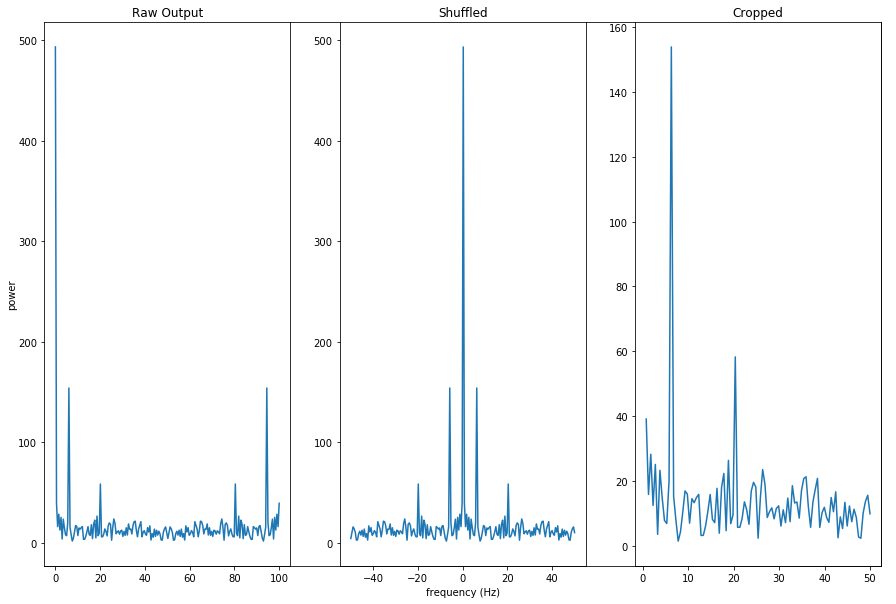

In [14]:
ft = abs(scipy.fftpack.fft(x)) #take fft and take magnitude 
#(abs gives magnitude when input is complex)
freq_axis = np.linspace(0.0, 1.0/(step_size), len(t))

freq_axis_correct = np.linspace(0, 1.0/(step_size), len(t)) - 1.0/(2*step_size)
ft_correct = np.zeros(size(ft))
ft_correct[len(t)/2:] = ft[:len(t)/2]
ft_correct[:len(t)/2] = np.transpose(ft[len(t)/2:])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(freq_axis, ft)
ax2.plot(freq_axis_correct, ft_correct)
ax3.plot(freq_axis_correct[len(t)/2 + 1:], ft_correct[len(t)/2 + 1:])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('power')

ax1.set_title('Raw Output')
ax2.set_title('Shuffled')
ax3.set_title('Cropped')

Now that we know what frequency components exist in the signal, we can design filters to attenuate any specific frequencies we do not want, or broadband noise in general. There are numerous filter options, and choosing one is usually a trade off between computation time, ripple in the stopband/passband, and the desire for recursive/nonrecursive methods. In this example, we will implement the commonly used Butterworth filter, which has a flat pass band and approaches ideal as the order is increased. If you would like more details on other filter options, the following is a great resource (although for MATLAB, analagous options exist in Python):

https://www.mathworks.com/help/signal/examples/practical-introduction-to-digital-filter-design.html

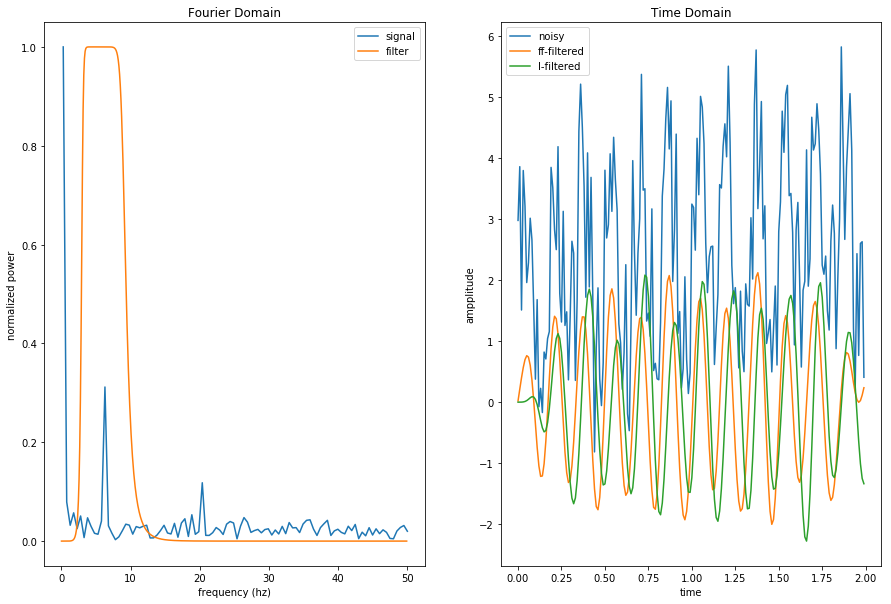

In [15]:
# Lets design a band pass filter to get our target frequency
# The high and low cutoffs must be mapped [0,1]
# This highest cutoff possible - fs/2 - is 1
def band_pass_filter(cutoff_low, cutoff_high, step_size, order=3):
    low = cutoff_low*step_size*2 
    high = cutoff_high*step_size*2
    
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

b, a = band_pass_filter(3, 9, step_size, order=7)
w, h = signal.freqz(b, a) #frequency response of the filter

fig_image = plt.figure()
ax1 = fig_image.add_subplot(121)
ax2 = fig_image.add_subplot(122)

ax1.plot(freq_axis_correct[len(t)/2:], ft_correct[len(t)/2:]/ft_correct[len(t)/2:].max())
ax1.plot(1/(2*step_size*np.pi)*w, abs(h))

filtered_signal_ff = signal.filtfilt(b, a, x) 
filtered_signal_lf = signal.lfilter(b, a, x) 
#perform the filtering
## signal.filtfilt() filters without introducing a phase delay, whereas signal.lfilter()
## introduces some time delay to the signal

ax2.plot(t, x)
ax2.plot(t, filtered_signal_ff)
ax2.plot(t, filtered_signal_lf)

ax1.set_xlabel('frequency (hz)')
ax1.set_ylabel('normalized power')
ax1.set_title('Fourier Domain')
ax1.legend(['signal', 'filter'])
ax2.set_xlabel('time')
ax2.set_ylabel('ampplitude')
ax2.set_title('Time Domain')
ax2.legend(['noisy','ff-filtered', 'l-filtered'])



We saw in the above example what a filter looks like in the Fourier domain. In fact, the method of applying a filter differs in time and frequency. In the Fourier domain, we could imagine simply multiplying the signal and the filter, attenuating everything outside the passband, and retaining everything within the passband. This multiplication in frequency is actually a different operation -- convolution -- in time. The following example of taking a running average will help solidfy this. 

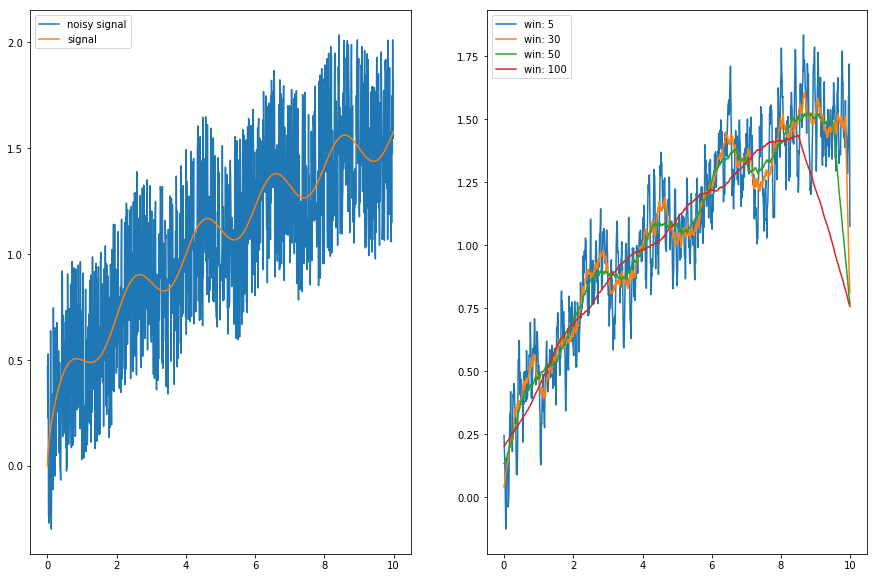

In [16]:
# Running average example
t_baseline = np.arange(0, 10, step_size)
y = 0.1*sin(2*np.pi*0.5*t_baseline) + 0.5*np.sqrt(t_baseline) 


#noisy signal
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

y_noise = y + np.random.rand(len(y)) -0.5

ax1.plot(t_baseline, y_noise)
ax1.plot(t_baseline, y)


#want to get rid of high frequency variations, but keep underlying
#not necessarily periodic

win_length = [5, 30, 100, 300]
for val in win_length:
    win = np.ones(val)/val #normalize
    avged_signal = signal.convolve(y_noise, win, mode='same')
    ax2.plot(t_baseline, avged_signal)
    
ax2.legend(['win: 5', 'win: 30', 'win: 50', 'win: 100'])
ax1.legend(['noisy signal', 'signal'])
# Notive the edge effects.. think about why these exist!

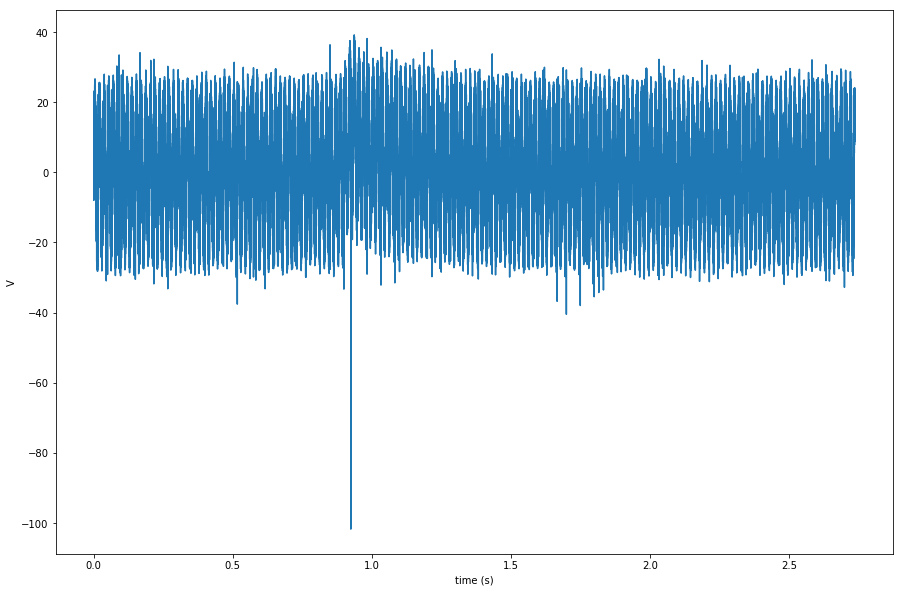

In [17]:
#### Artifically noisy ephys trace

#Note that by opening the file using "with", it is automatically closed when finished
with h5py.File('sweeps.h5', 'r') as f:
    noisy_trace = np.array(f['acquisition/timeseries/data_00001/electrode_2'])
    noisy_trace_unit = f['acquisition/timeseries/data_00001/electrode_2'].attrs['unit']
    time = np.array(f['acquisition/timeseries/data_00001/time'])
    time_unit = f['acquisition/timeseries/data_00001/time'].attrs['unit']
    
noisy_trace += 20*sin(2*np.pi*60*time) #Add some 60 Hz noise
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, noisy_trace)
ax.set_xlabel('time (s)')
ax.set_ylabel('V')


In [18]:
############### Exercise: filter this horrendous trace! ###############
############### start by trying to find any corrupting frequencies by bring the trace into the
############### frequency domain

(<matplotlib.text.Text at 0x1125a0dd0>, <matplotlib.text.Text at 0x1119f24d0>)

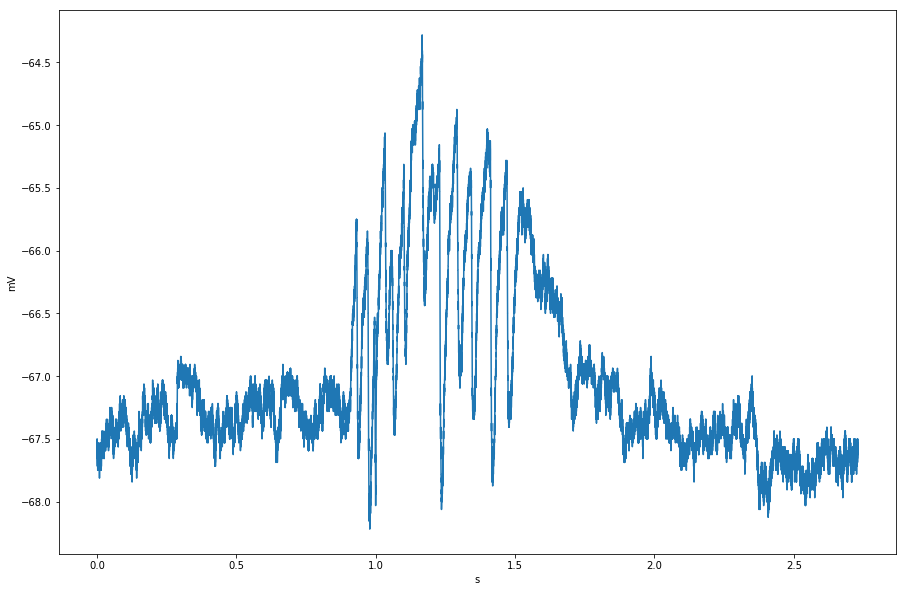

In [19]:
# Let's try a slightly more complicated signal
with h5py.File('sweeps.h5', 'r') as f:
    electrode_2 = np.array(f['acquisition/timeseries/data_00000/electrode_2'])
    electrode_2_unit = f['acquisition/timeseries/data_00000/electrode_2'].attrs['unit']
    time = np.array(f['acquisition/timeseries/data_00000/time'])
    time_unit = f['acquisition/timeseries/data_00000/time'].attrs['unit']
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, electrode_2)
ax.set_xlabel(time_unit), ax.set_ylabel(electrode_2_unit) 

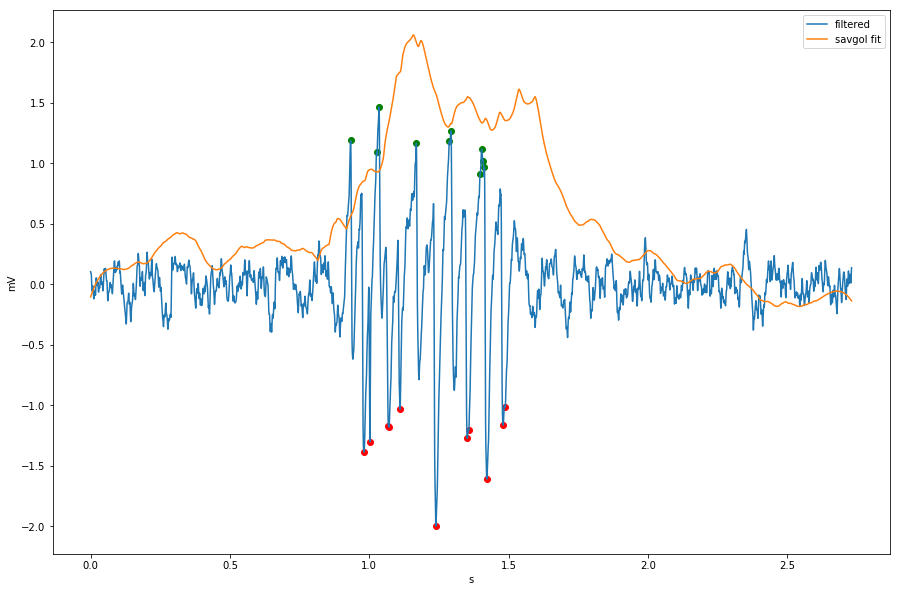

In [20]:
################ EXERCISE ###############
# Here are some tools

# take derivative, and re-integrate to eliminate offset
def zero_baseline(data):
    deriv = np.diff(data)
    integrated_data = scipy.cumsum(deriv)
    
    return integrated_data


#filter: this function will function as a low, high, or band pass filter, but you will 
#most likely want to use it as a low pass filter for the signal above 
def filter_signal(data, sample_rate, cutoff_low = None, cutoff_high = None, order=5):
    if cutoff_low is not None:
        l = cutoff_low/(2*sample_rate)
        if cutoff_high is not None:
            filt_type = 'band'
            h = cutoff_high/(2*sample_rate)
            
            filts = [l, h]
        else:
            filt_type = 'low'
            filts = [l]
    elif cutoff_high is not None:
        filt_type = 'high'
        h = cutoff_high/(2*sample_rate)
        filts = [h]
    else:
        return 'Need some type of filter!'
    
    b, a = signal.butter(order, filts, btype = filt_type)
    
    filtered_data = signal.lfilter(b, a, data)
    
    return filtered_data
    

# savitsky golay: keep in mind that the return signal may be shorter in time
# and you will need to adjust the time vector
def savgol(data, win_len, sample_rate, order=3):
    
    if not win_len % 2:
        win_len += 1
        
    return scipy.signal.savgol_filter(data, win_len, order)
           

# peak detection, takes in optional threshold arguments
def find_peaks(data, pos_threshold = None, neg_threshold = None):
    
    if pos_threshold is None:
        pos_threshold = np.mean(data) + 2.5*np.std(data)
    if neg_threshold is None:
        neg_threshold = np.mean(data) - 2.5*np.std(data)
        
    sig_deriv = np.diff(data)
    
    sig_deriv = (sig_deriv > 0).astype(np.byte) 
    
    neg_peak_opts = np.argwhere(sig_deriv[1:] - sig_deriv[:-1] == 1) 
    pos_peak_opts = np.argwhere(sig_deriv[1:] - sig_deriv[:-1] == -1)
    
    pos = pos_peak_opts[data[pos_peak_opts] > pos_threshold]
    neg = neg_peak_opts[data[neg_peak_opts] < neg_threshold]
    
    return pos, neg


############# EXERCISE ###############
## use the above functions and suggestions below to play with various filtering options

sample_rate = 1/(time[1] - time[0])

zeroed = zero_baseline(electrode_2)
filtered = filter_signal(zeroed, sample_rate, cutoff_low = 1000)
win = 6000 #adjust this to change smoothing
sav = savgol(filtered, win, sample_rate)

baseline_subtracted = filtered[0:len(sav)] - sav

pos, neg = find_peaks(baseline_subtracted)
####################################


#### plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time[0:len(baseline_subtracted)], baseline_subtracted)
ax.plot(time[0:len(sav)], sav)
ax.legend(['filtered', 'savgol fit'])
ax.scatter(time[neg], baseline_subtracted[neg], color='r')
ax.scatter(time[pos], baseline_subtracted[pos], color='g')
ax.set_xlabel('s')
ax.set_ylabel('mV')

<h2> 2D Filtering </h2>

Many of the same principles from filtering in 1D will also apply to 2D (image) filtering. A Gaussian filter will smooth the data in 2D (much like a running average), while a median filter will eliminate some salt-and-pepper noise while preserving the integrity of edges. 

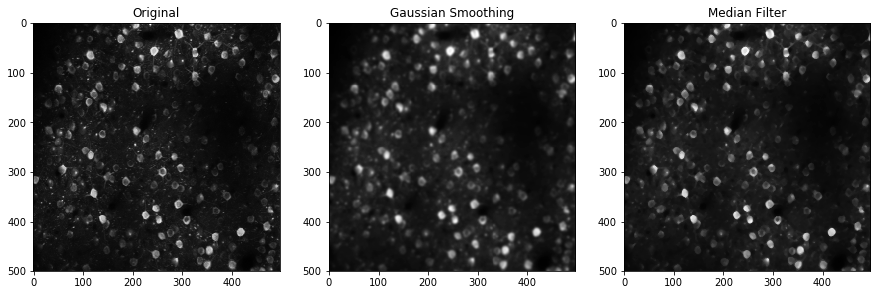

In [21]:
fig_image = plt.figure()
ax1 = fig_image.add_subplot(131)
ax2 = fig_image.add_subplot(132)
ax3 = fig_image.add_subplot(133)


cell_im = ndi.imread('BOb.png')[...,0]

cell_smooth = ndi.gaussian_filter(cell_im, sigma=2)
cell_median = ndi.median_filter(cell_im, size=5, mode='constant')

ax1.imshow(cell_im, cmap=plt.cm.gray)
ax1.set_title('Original')
ax2.imshow(cell_smooth, cmap=plt.cm.gray)
ax2.set_title('Gaussian Smoothing')
ax3.imshow(cell_median, cmap=plt.cm.gray)
ax3.set_title('Median Filter')

If our eventual goal is to find regions of interest corresponding to cells, one challenging factor may be the apparent difference in morphology between the cells in the images above. You will notice that some are filled (solid) while others appear to be rings. We can take advantage of a morphological operation, dilation, to essentially "fill" all rings. In dilation, each pixel value is replaced with the maximum pixel value of the region around it. This will act to both enlarge and fill the circle. The extent of this is determined by the size of the structuring element used for dilation.

http://utam.gg.utah.edu/tomo03/03_mid/HTML/node119.html

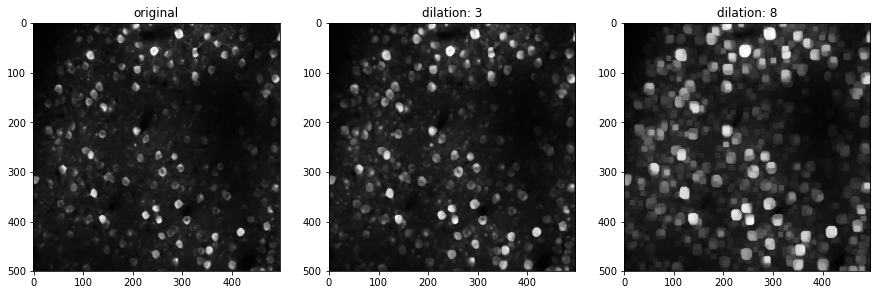

In [22]:
fig_image = plt.figure()
ax1 = fig_image.add_subplot(131)
ax2 = fig_image.add_subplot(132)
ax3 = fig_image.add_subplot(133)

# Let's use our median filtered image for the rest of computation
ax1.imshow(cell_median, cmap=plt.cm.gray)

threshold_cell = cell_median.copy()

dilation_3 = ndi.morphology.grey_dilation(threshold_cell, size=(3,3))
dilation_8 = ndi.morphology.grey_dilation(threshold_cell, size=(8,8))

ax2.imshow(dilation_3, cmap=plt.cm.gray)
ax3.imshow(dilation_8, cmap=plt.cm.gray)

ax1.set_title('original')
ax2.set_title('dilation: 3')
ax3.set_title('dilation: 8')

It may be useful to project this image into 3D space in order to get a better understanding of relative pixel values between background and cells. 

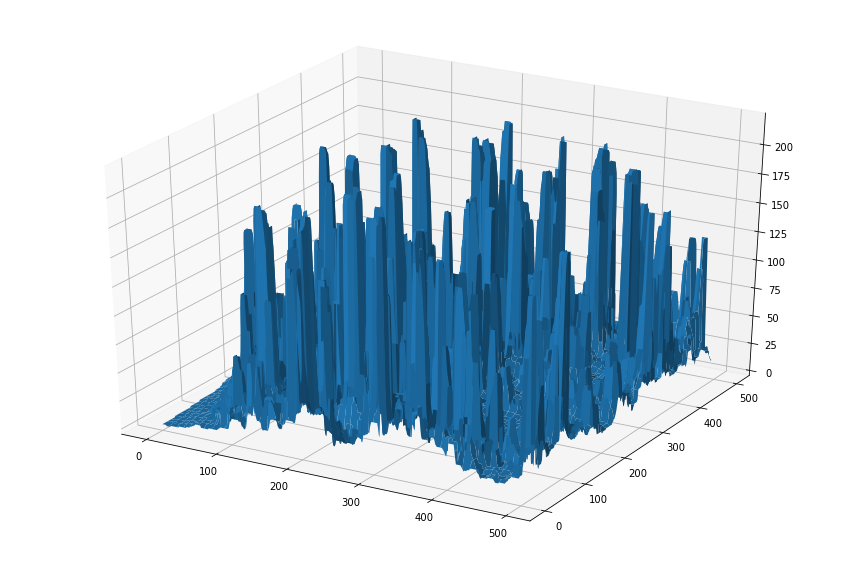

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(
    np.arange(0, cell_im.shape[1], 1), #note: x and y are reversed from the actual image 
    np.arange(0, cell_im.shape[0], 1)  #when passing to plot_surface()
)

ax.plot_surface(x, y, dilation_8)

From the dilated images and 3D projection above, we can see that any rings have been properly filled, but that some salt-and-pepper noise our median filter did not catch has been dilated to nearly the size of the cell! To combat this, we can perform a similar procedure, erosion, with a structuring element of the same size. Erosion replaces each pixel with the minimum pixel value of its surroundings. Note that erosion is not quite the inverse of dilation: the rings that we filled will remain closed (they are surrounded by a neighborhood or bright pixels), but the size of the object will decrease. From there, we can pick a threshold value to eliminate background some background noise. It is best to be conservative with this value; you ideally want to eliminate a relatively constant background signal, but avoid eliminating any bright objects. Even if these do not appear to be cells, we can filter our by size when performing object detection. 

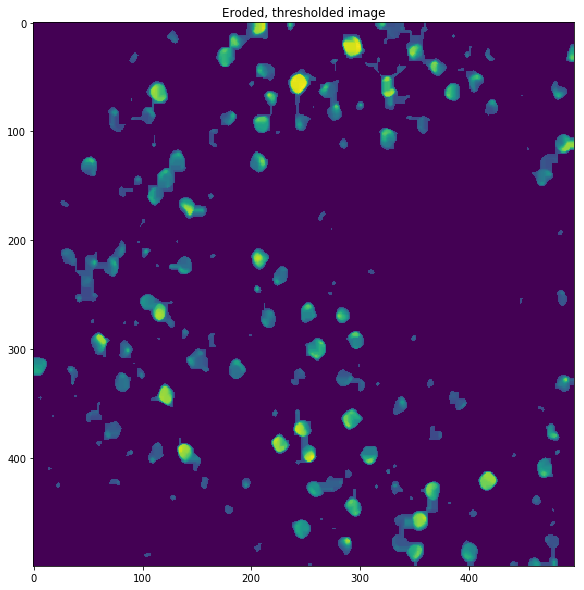

In [24]:
# Pick a threshold based on the above image. @Luke: do this in a more quantitiative way?

eroded_image = ndi.grey_erosion(dilation_8, size=(8,8)) 
threshold_im = eroded_image.copy()
threshold_im[eroded_image< 50] = 0

fig_image = plt.figure()
ax = fig_image.add_subplot(111)
ax.imshow(threshold_im)
ax.set_title('Eroded, thresholded image')

The scikit-image packages contains several "blob detection" modules, and we will employ two of them here to attempt to classify cells in the above image:

1. Difference of Gaussians: this method involves the subtraction of two gaussian filters (similar to the ones employed earlier). This is analagous to passband in signal processing, and in an image, will extract the edges of an object. 

2. Laplacian of Gaussians: A gaussian filter first acts to smooth the image, and a Laplacian (which takes the second derivative, $L_{xx} + L_{yy} $) performs edge detection, but with a positive response moving into the blob, and a negative response moving out of the blob. 

Read more here:

http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog

http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log

http://fourier.eng.hmc.edu/e161/lectures/gradient/node9.html

http://fourier.eng.hmc.edu/e161/lectures/gradient/node8.html

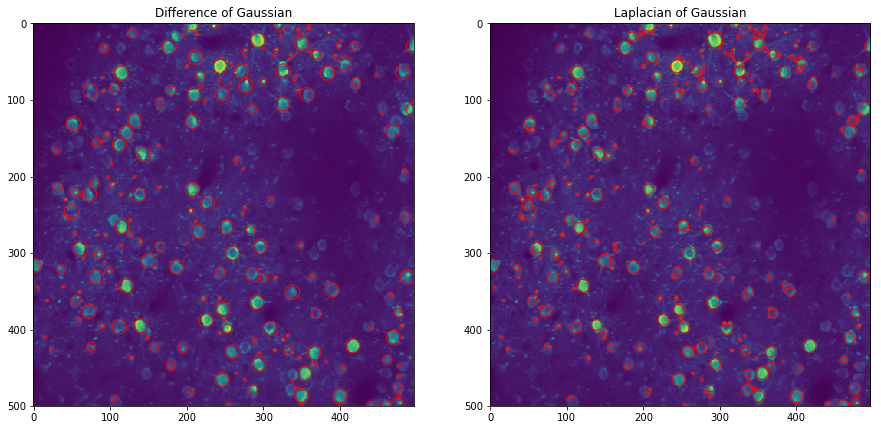

In [25]:
DoG = skimage.feature.blob_dog(threshold_im, max_sigma=10, threshold=0.005) 
LoG = skimage.feature.blob_log(threshold_im, max_sigma=10, threshold=0.01)
# play around with optional parameters, max_sigma & threshold, to alter the size/brightness
# of the blobs detected

fig_image = plt.figure()
ax1 = fig_image.add_subplot(121)
ax2 = fig_image.add_subplot(122)


ax1.imshow(cell_im) #back to our original images
ax2.imshow(cell_im)


for roi_DoG in DoG: 
    y_DoG = roi_DoG[0]
    x_DoG = roi_DoG[1]
    rad_DoG = roi_DoG[2] * sqrt(2)
    
    ##### EXERCISE ########
    
    # filter by size
    # if rad > threshold_pixels:
        # color = 'r'
        
    # else:
        # color = 'g'
        
    ax1.add_patch(plt.Circle((x_DoG,y_DoG), rad_DoG, color='r', fill=0))

for roi_LoG in LoG:
    y_LoG = roi_LoG[0]
    x_LoG = roi_LoG[1]
    rad_LoG = roi_LoG[2] * sqrt(2)
    
    ##### EXERCISE ########
    
    # filter by size
    # if rad > threshold_pixels:
        # color = 'r'
        
    # else:
        # continue
    
    
    ax2.add_patch(plt.Circle((x_LoG,y_LoG), rad_LoG, color='r', fill=0))


ax2.set_title('Laplacian of Gaussian')
ax1.set_title('Difference of Gaussian')